# Overlap beta-binomial mixture result with DMM
- how much of beta-binom is captured by DMM
- how much of DMM is captured by beta-binom
- which cluster do beta-binom fall inside DMM?

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from pybedtools import BedTool
from plot_params import *
import matplotlib.pyplot as plt
basedir = Path('/tscc/nfs/home/hsher/scratch/ABC_2rep')
outstem='K562_rep6'

In [2]:

window_bed = BedTool('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_df = pd.read_csv(window_bed.fn, sep = '\t')


# Some gold standards

In [3]:

window_bed = BedTool('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_df = pd.read_csv(window_bed.fn, sep = '\t')

pum_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_pum2.homer.motif', sep = '\t')
pum_motif = pum_motif.loc[pum_motif['Motif Name']=='1-TGTATATA']
pum_motif['windowstrand']=pum_motif['PositionID'].map(window_df.set_index('name')['strand'])
pum_motif.dropna(inplace = True)
pum_motif = pum_motif.loc[pum_motif['Strand']==pum_motif['windowstrand']]

rbfox2_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_rbfox2.homer.motif', sep = '\t')
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Motif Name'].isin(
    ['1-TGCATG', '2-GCATST', '3-AGCATG','8-TGCACA', '9-TGCACG']                                                            
)
]
rbfox2_motif['windowstrand']=rbfox2_motif['PositionID'].map(window_df.set_index('name')['strand'])
rbfox2_motif.dropna(inplace = True)
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Strand']==rbfox2_motif['windowstrand']]


In [4]:
ground_truth_skipper = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
ground_truth_skipper.sum().sort_values()

EIF3G         213
ZC3H11A      4722
PUM2         7147
RBFOX2      12206
DDX3        12334
LIN28B      26668
IGF2BP2     28834
SF3B4       44025
FAM120A     50622
PRPF8      102243
dtype: int64

# Overlap between the two

In [5]:
def read_beta_and_dmm_enriched_windows(outstem, rbp, fc_raw_thres = None):
    beta_df = pd.read_csv(basedir / 'beta-mixture_CC'/ f'{outstem}.{rbp}.window_score.tsv',
                          sep = '\t', index_col = 0)
    dmm_df = pd.read_csv(basedir / 'DMM' / f'{outstem}.megaoutputs.tsv',
                         sep = '\t', index_col = 0)
    if fc_raw_thres is None:
        dmm_df['is_dmm']=dmm_df[f'{outstem}.{rbp}']
    else:
        dmm_df['is_dmm']=(dmm_df[f'{outstem}.{rbp}'])&(dmm_df[f'fc_raw:{outstem}.{rbp}'].ge(fc_raw_thres))
    dmm_df['is_beta']=beta_df.set_index('name')['enriched']
    dmm_df['is_eclip']=dmm_df['name'].isin(ground_truth_skipper.loc[ground_truth_skipper[rbp]].index)
    return dmm_df

is_pum_motif       False      True
is_dmm is_beta                    
False  False    0.990666  0.009334
       True     1.000000       NaN
True   False    0.929515  0.070485
       True     0.846626  0.153374
is_eclip           False      True
is_dmm is_beta                    
False  False    0.971024  0.028976
       True     0.945055  0.054945
True   False    0.632893  0.367107
       True     0.380368  0.619632


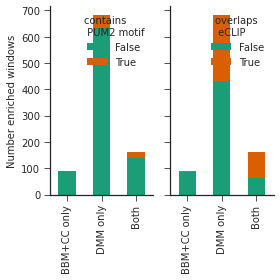

In [22]:

rbp='PUM2'
dmm=read_beta_and_dmm_enriched_windows(outstem, rbp, fc_raw_thres = None)
dmm['is_pum_motif']=dmm['name'].isin(pum_motif['PositionID'])

f, ax = plt.subplots(1,2, figsize = (4,4), sharey = True)

cnt = dmm.groupby(by = ['is_dmm', 'is_beta'])['is_pum_motif'].value_counts().unstack()
print(cnt.div(cnt.sum(axis = 1), axis = 0))
dmm.groupby(by = ['is_dmm', 'is_beta'])['is_pum_motif'].value_counts().unstack().iloc[1:].plot.bar(
    stacked = True, ax = ax[0])
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(['BBM+CC only', 'DMM only', 'Both'])
ax[0].legend(title = 'contains \n PUM2 motif', loc = 'upper right')

cnt = dmm.groupby(by = ['is_dmm', 'is_beta'])['is_eclip'].value_counts().unstack()
print(cnt.div(cnt.sum(axis = 1), axis = 0))
dmm.groupby(by = ['is_dmm', 'is_beta'])['is_eclip'].value_counts().unstack(
).iloc[1:].plot.bar(stacked = True, ax = ax[1])
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['BBM+CC only', 'DMM only', 'Both'])
ax[0].set_ylabel('Number enriched windows')
_ = [a.set_xlabel('') for a in ax]
ax[1].legend(title = 'overlaps \n eCLIP', loc = 'upper right')
sns.despine()
plt.tight_layout()
#plt.subplots_adjust(left=1.5, right = 1.5)
plt.savefig(figdir/'PUM2_compare_betaDMM.pdf')


In [7]:
cluster_anno = pd.read_csv(basedir / 'DMM' / f'{outstem}.cluster_summary.csv', index_col = 0)

In [8]:
cluster_cnt = dmm.groupby(by = ['is_dmm', 'is_beta'])['cluster'].value_counts().unstack().iloc[1:].fillna(0)
cluster_cnt.loc[:,cluster_cnt.sum(axis = 0)>0].T

is_dmm  False   True      
is_beta  True  False  True
cluster                   
V1        0.0    4.0   0.0
V10       0.0    1.0   0.0
V11       0.0   14.0   1.0
V12       0.0   65.0   0.0
V13       0.0   26.0  13.0
V14       0.0    4.0   0.0
V15       0.0   13.0   1.0
V16       0.0   19.0   4.0
V17       0.0    4.0   0.0
V18       0.0    6.0   0.0
V19       0.0    3.0   0.0
V2        0.0   22.0   0.0
V20       0.0    1.0   0.0
V21       0.0    4.0   1.0
V22       0.0    4.0   0.0
V23       0.0   37.0  10.0
V24       0.0    2.0   0.0
V25       0.0    3.0   0.0
V26       0.0   13.0   0.0
V27       0.0    1.0   0.0
V28       0.0    3.0   0.0
V29       0.0    6.0   1.0
V30       0.0    5.0   1.0
V31       0.0  177.0  71.0
V32       0.0    3.0   0.0
V33       0.0    2.0   0.0
V34       0.0    2.0   1.0
V35       0.0    5.0   0.0
V36       0.0    8.0   1.0
V37       0.0   13.0   1.0
V38       0.0    6.0   1.0
V4        0.0   12.0   0.0
V41       0.0    5.0   0.0
V42       0.0   14.0   3.0
V43       0.0    3.0   0.0
V44      91.0  132.0  52.0
V45       0.0    3.0   0.0
V46       0.0    2.0   1.0
V6        0.0    9.0   0.0
V7        0.0    9.0   0.0
V8        0.0    1.0   0.0
V9        0.0   15.0   0.0

In [9]:
dmm['fc_raw_pass']=dmm[f'fc_raw:{outstem}.{rbp}'].ge(1)
dmm.loc[dmm['is_dmm']].groupby(by = 'is_eclip')[f'fc_raw_pass'].mean()

is_eclip
False    1.0
True     1.0
Name: fc_raw_pass, dtype: float64

In [10]:
dmm.groupby(by = ['is_dmm', 'is_beta'])['is_pum_motif'].value_counts().unstack()

is_pum_motif       False    True
is_dmm is_beta                  
False  False    136279.0  1284.0
       True         91.0     NaN
True   False       633.0    48.0
       True        138.0    25.0

Text(0.5, 0, '# enriched windows')

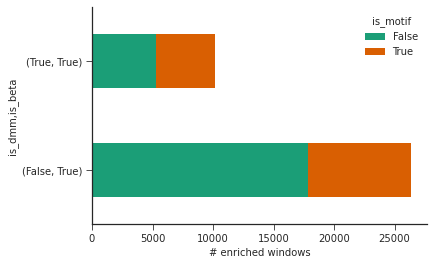

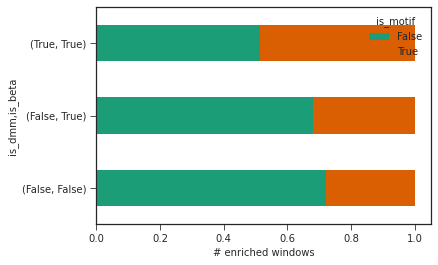

In [11]:
rbp='RBFOX2'
dmm=read_beta_and_dmm_enriched_windows(outstem, rbp, fc_raw_thres = None)
dmm['is_motif']=dmm['name'].isin(rbfox2_motif['PositionID'])
cnt = dmm.groupby(by = ['is_dmm', 'is_beta'])['is_motif'].value_counts().unstack()
dmm.groupby(by = ['is_dmm', 'is_beta'])['is_motif'].value_counts().unstack().iloc[1:].plot.barh(stacked = True)
plt.xlabel('# enriched windows')
sns.despine()
plt.savefig(figdir/'RBFOX2_compare_betaDMM.pdf')
cnt.div(cnt.sum(axis = 1), axis = 0).plot.barh(stacked = True)
plt.xlabel('# enriched windows')

Text(0.5, 0, '# enriched windows')

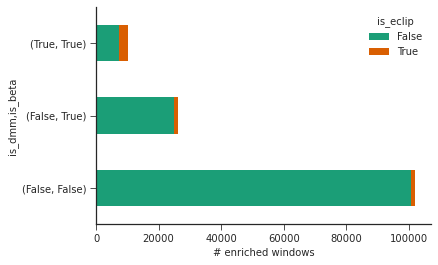

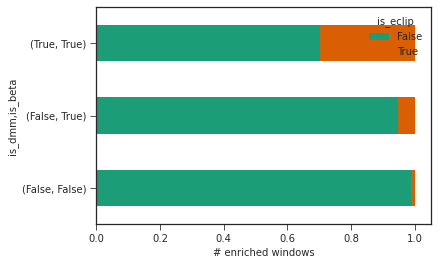

In [12]:
cnt = dmm.groupby(by = ['is_dmm', 'is_beta'])['is_eclip'].value_counts().unstack()
dmm.groupby(by = ['is_dmm', 'is_beta'])['is_eclip'].value_counts().unstack().plot.barh(stacked = True)
plt.xlabel('# enriched windows')
sns.despine()
plt.savefig(figdir/'RBFOX2_compare_betaDMM_eCLIP.pdf')
cnt.div(cnt.sum(axis = 1), axis = 0).plot.barh(stacked = True)
plt.xlabel('# enriched windows')
#dmm.groupby(by = ['is_dmm', 'is_beta'])['cluster'].value_counts().unstack().iloc[1:].plot.bar(stacked = True)

# Evaluate all

In [13]:

rbps = [f.name.split('.')[1] for f in list((basedir/'DMM').glob(f'{outstem}.*enriched_windows*'))]

counts = []
for rbp in rbps:
    dmm=read_beta_and_dmm_enriched_windows(outstem, rbp, fc_raw_thres = None)
    print(dmm.loc[dmm[f'{outstem}.{rbp}'], f'fc_raw:{outstem}.{rbp}'].min())
    cnt = dmm.groupby(by = ['is_dmm', 'is_beta'])['is_eclip'].value_counts().unstack()
    frac_eclip = cnt[True].div(cnt.sum(axis = 1))
    frac_eclip.name = rbp
    counts.append(frac_eclip)
    
    # print the culprit
    cluster_cnt = dmm.groupby(by = ['is_dmm', 'is_beta'])['cluster'].value_counts().unstack().iloc[1:].fillna(0)
    try:
        print('Non-beta-cluster:',cluster_cnt.loc[True, False].idxmax(), rbp)
    except:
        pass
    

3.307713340540774
Non-beta-cluster: V31 PUM2
1.556649455204098
Non-beta-cluster: V7 IGF2BP2
4.493642817836555
Non-beta-cluster: V15 EIF3G
1.921391301788
2.2084460979903744
Non-beta-cluster: V19 LIN28B
0.8429776836425564
Non-beta-cluster: V13 FAM120A
2.076935038708178
2.6985774843633923
2.615346949657633
1.5221012245318897
Non-beta-cluster: V4 PRPF8


In [14]:
counts = pd.concat(counts, axis = 1)

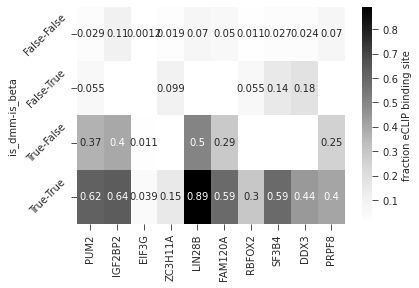

In [15]:

g=sns.heatmap(counts, cmap = 'Greys', annot = True,
           cbar_kws={'label':'fraction eCLIP binding site'})
plt.yticks(rotation=45)
plt.savefig(figdir/'compare_betaDMM_eCLIP.pdf')